# Wavenet for time series prediction

In this tutorial, we show how to set up and train an WaveNet-based regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.topologies as topologies

import deep4cast.custom_metrics as metrics
from pandas import read_table

%matplotlib inline

# Fix random number seed for reproducibility
np.random.seed(3) 

Using TensorFlow backend.


## Data preparation

In [2]:
# Load the data from file
filename = '../data/energy.csv'
df = read_table(filename, sep=',')
df_feat = df.set_index('timestamp')
df_feat.load = df_feat.load.apply(np.log1p)
df_feat.load = df_feat.load.diff()
df_feat = df_feat.dropna()

# Prepare the data set
data = df_feat[['load', 'temp']].astype('float32').values
data = np.expand_dims(data, axis=0)

# We just need a small holdout dataset for evaluation purposes
holdout = 48 # hours
train_data = data[:,:-holdout,[0]]
test_data = np.expand_dims(df[['load', 'temp']].astype('float32').values, axis=0)[:,-holdout:,[0]]

The time series below show hourly energy load data and hourly temperature data. We can use the temperature data as covariate for predicting the hourly load data into the future.

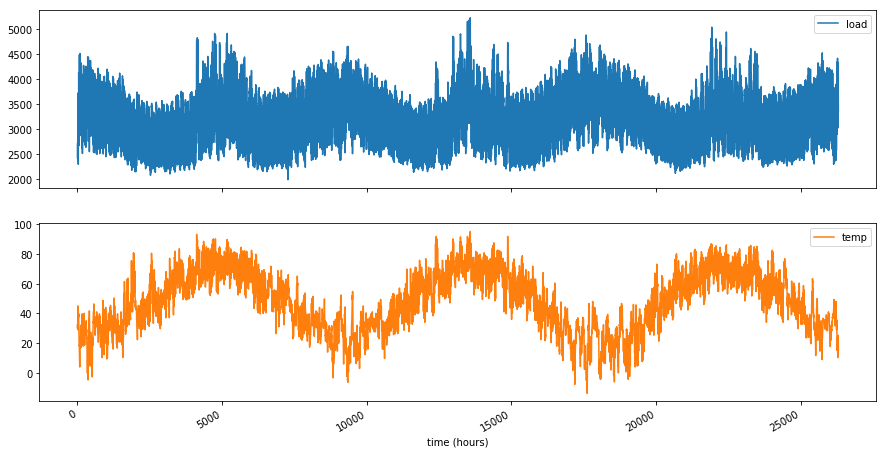

In [3]:
# Let plot the data
df.plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

# Modeling

Before we can fit a time series model, we need to specify a neural network topology that is suitable for this kind of time series. In this example, we opt for a WaveNet like topology that consists of stacked causal convolutional layers with residual connections.

In [4]:
topology = topologies.WaveNet(filters=128, num_layers=4)

In [5]:
forecaster = Forecaster(
    topology,
    lag=holdout*2,  # This is the number of time steps used to predict the future for each data point
    horizon=holdout,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    patience=2
)

In [6]:
forecaster.fit(train_data, targets=[0], verbose=1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 23487 samples, validate on 2578 samples
Epoch 1/100
23487/23487 [==============================] - 43s 2ms/step - loss: -1.3545 - val_loss: -1.8617
Epoch 2/100
23487/23487 [==============================] - 35s 1ms/step - loss: -2.1303 - val_loss: -2.1751
Epoch 3/100
23487/23487 [==============================] - 34s 1ms/step - loss: -2.3513 - val_loss: -2.2666
Epoch 4/100
23487/23487 [==============================] - 34s 1ms/step - loss: -2.4780 - val_loss: -2.2461
Epoch 5/100
23487/23487 [==============================] - 34s 1ms/step - loss: -2.5634 - val_loss: -2.4150
Epoch 6/100
23487/23487 [==============================] - 40s 2ms/step - loss: -2.6282 - val_loss: -2.4328
Epoch 7/100
23487/23487 [==============================] - 39s 2ms/step - loss: -2.6784 - val_loss: -2.4748
Epoch 8/100
23487/23487 [==============================] - 39s 2ms/step - loss: -2.7190 - val_loss: -2.5091
Epoc

We prevent overfitting of the model using early stopping when the validation set error stops imporoving. We use a patience parameters in the forecaster object to control when to stop.

Text(0,0.5,"['Loss', 'Validation Loss']")

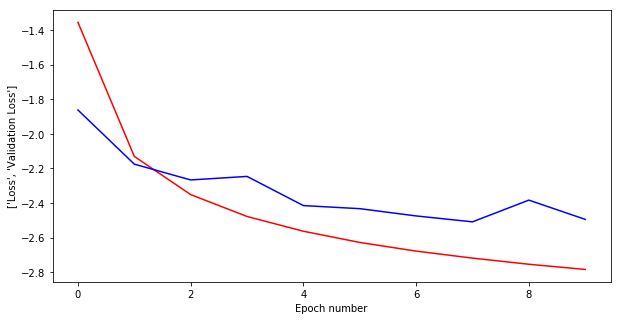

In [7]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'b')
plt.xlabel('Epoch number')
plt.ylabel(['Loss', 'Validation Loss'])

# Evaluation

In [24]:
predictions = forecaster.predict(data=train_data, n_samples=2000)

In [25]:
samples = predictions['samples'].squeeze()
samples = np.cumsum(samples, axis=1) + np.log1p(df.load.values[-holdout-1])
samples = np.expm1(samples)
predictions['mean'] = np.mean(samples, axis=0)
predictions['samples'] = samples
predictions['lower_quantile'] = np.percentile(samples, q=5, axis=0)
predictions['upper_quantile'] = np.percentile(samples, q=95, axis=0)

One meaningful way of evaluating model performance is the Mean Absolute Percentage Error (MAPE), which we use here to see how well we are doing.

In [26]:
print('MSE: {}'.format(round(metrics.mse(predictions['mean'], test_data[0,:,0]), 2)))
print('MAPE: {}%'.format(round(metrics.mape(predictions['mean'], test_data[0,:,0]), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(predictions['mean'], test_data[0,:,0]), 2)))

MSE: 13082.01
MAPE: 2.49%
SMAPE: 2.52%


Lastly, we can check how our predictions compare with the data.

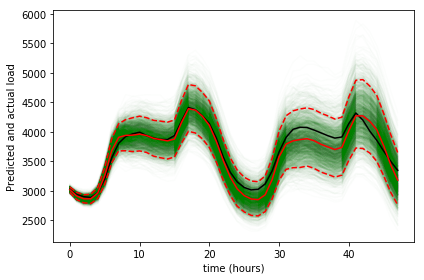

In [30]:
# We're printing the test set data and the predictions for the load data
plt.plot(predictions['samples'][:,:].T, 'g', alpha=0.01)
plt.plot(test_data[0,:,0].T, 'k')
plt.plot(predictions['mean'], 'r')
plt.plot(predictions['lower_quantile'], 'r--')
plt.plot(predictions['upper_quantile'], 'r--')
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()